In [1]:
library(Seurat)
library(dplyr)
library(tidyverse)
library(Matrix)
library(CellChat)
library(patchwork)
library(stringr)
library(here)

Loading required package: SeuratObject

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


# Code to generate the SMC_subset Seurat object

Data from Lee _et. al._, Nature Genetics, 2020, raw scRNA-seq data accessible at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE132465.

```
require(data.table)
raw_counts <- fread(here("data", "GSE132465_GEO_processed_CRC_10X_raw_UMI_count_matrix.txt"),
    header = TRUE,
    sep = "\t",
    check.names = FALSE
) %>% as.data.frame()
rownames(raw_counts) <- raw_counts[, 1]
raw_counts <- raw_counts[, -1]

meta <- read.table(here("GSE132465_GEO_processed_CRC_10X_cell_annotation.txt"), sep = "\t", header = TRUE)
rownames(meta) <- meta[, 1]
meta <- meta[, -1]
head(meta)

SMC <- CreateSeuratObject(counts = as.sparse(raw_counts), meta.data = meta, project = "SMC")
SMC
head(SMC@meta.data)
rm(raw_counts)

unique(SMC@meta.data$Sample)
unique(SMC@meta.data$Cell_type)
unique(SMC@meta.data$Sample_type)
SMC@meta.data <- SMC@meta.data %>% separate(Sample, c("Patient", "Sample_type"), "-")

dim(SMC) # 33694 63689
SMC_subset <- subset(SMC, subset = Cell_type %in% c("Epithelial cells", "Stromal cells"))
dim(SMC_subset) # 33694  24472
rm(SMC)

SMC_subset[["percent.mt"]] <- PercentageFeatureSet(SMC_subset, pattern = "^MT-")
VlnPlot(SMC_subset, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, group.by = "Patient")
unique(SMC_subset@meta.data$Cell_subtype)

# Exploration

SMC_subset_tumour <- subset(SMC_subset, subset = Sample_type == "T")
unique(SMC_subset_tumour@meta.data$Cell_subtype)
SMC_subset_normal <- subset(SMC_subset, subset = Sample_type == "N")
unique(SMC_subset_normal@meta.data$Cell_subtype)

# ------
# ---
# Data preprocessing
# ---
# ------

# Regress to mitochondria content
sample_filt_sct <- SCTransform(SMC_subset,
    vars.to.regress = "percent.mt",
    variable.features.n = 10000
)

(cell_num_filt <- SMC_subset[["RNA"]]@data@Dim[2]) # 24472
(feature_num_filt <- SMC_subset[["RNA"]]@data@Dim[1]) # 33694

# ---
# Normalisation and data scaling
# ---

sample_filt_sct <- NormalizeData(sample_filt_sct,
    normalization.method = "LogNormalize",
    assay = "RNA"
) # normalisation
# sample_filt_sct <- ScaleData(sample_filt_sct, features = rownames(sample_filt_sct), assay = "RNA")

# ---
# Cell cycle analysis
# ---

# Curated list from Tirosh
# g2m.tirosh <- cc.genes.updated.2019$g2m.genes %>% str_to_sentence()

# CellCycle_geneSet -> collated from Tirosh and Macorsko
cc_genes <- read_tsv(here("ref", "CellCycle_geneSet.txt"))
s.features <- na.omit(cc_genes$s) %>% str_to_upper()
g2m.features <- na.omit(cc_genes$g2m) %>% str_to_upper()
g1.features <- na.omit(cc_genes$g1) %>% str_to_upper()

g1s.features <- unique(c(s.features, g1.features))
g1s.features <- setdiff(g1s.features, g2m.features) # Remove duplicates from g1s -> Check OneNote for justification

sample_filt_sct <- CellCycleScoring(sample_filt_sct,
    s.features = g1s.features,
    g2m.features = g2m.features,
    assay = "SCT",
    set.ident = TRUE
)

(g1.count <- length(WhichCells(object = sample_filt_sct, expression = Phase == "G1"))) # 4880
(g2m.count <- length(WhichCells(object = sample_filt_sct, expression = Phase == "G2M"))) # 5039
(s.count <- length(WhichCells(object = sample_filt_sct, expression = Phase == "S"))) # 14553

sample_filt_sct$CCDiff <- sample_filt_sct$S.Score - sample_filt_sct$G2M.Score # Cycling VS Quiescent

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~Normalise and regress CC~~~~~~~~~~~~~~~~~~~~~~~~~~#

sample_filt_sct <- SCTransform(sample_filt_sct,
    vars.to.regress = c("CCDiff", "percent.mt"),
    variable.features.n = 10000,
    assay = "SCT"
)

# ---
# Dimensionality Reduction
# ---

# PCA
sample_filt_sct <- RunPCA(sample_filt_sct)
VizDimLoadings(sample_filt_sct, dims = 1:4, reduction = "pca")
ElbowPlot(sample_filt_sct)
DimPlot(sample_filt_sct, reduction = "pca", group.by = "Cell_type", label = TRUE) + coord_equal()

# UMAP
sample_filt_sct <- RunUMAP(sample_filt_sct, dims = 1:48)
DimPlot(sample_filt_sct, reduction = "umap", group.by = "Cell_subtype")
DimPlot(sample_filt_sct, reduction = "umap", group.by = "old.ident")
DimPlot(sample_filt_sct, reduction = "umap", group.by = "Phase")

head(sample_filt_sct@meta.data)
unique(sample_filt_sct@meta.data$Sample_type)

p <- DimPlot(sample_filt_sct, reduction = "umap", group.by = "Sample_type") |
    DimPlot(sample_filt_sct, reduction = "umap", group.by = "Cell_subtype")
ggsave(here("output", "sample-type_cell-subtype.pdf"), width = 18, height = 5)
FeaturePlot(sample_filt_sct, features = c("EPCAM", "VIM"), reduction = "umap")
ggsave(here("output", "EPCAM-VIM.pdf"), width = 12, height = 5)

saveRDS(sample_filt_sct, here("output", "SMC_subset.rds"))
```

# Calculate UCell Scores

In [3]:
SMC_subset <- readRDS(here("Figure2_S2", "data", "SMC_subset.rds")) 
stem_signatures <- read.csv(here("Figure2_S2", "data", "QinCardoso_DEstem_human.csv"))
head(stem_signatures)

CSC <- stem_signatures %>%
    filter(CLUSTER == "CSC") %>%
    select(hGENE)
g_CSC <- CSC$hGENE

proCSC <- stem_signatures %>%
    filter(CLUSTER == "proCSC") %>%
    select(hGENE)
g_proCSC <- proCSC$hGENE

revCSC <- stem_signatures %>%
    filter(CLUSTER == "revCSC") %>%
    select(hGENE)
g_revCSC <- revCSC$hGENE

# UCell Score
SMC_subset_ucell <- UCell::AddModuleScore_UCell(
    obj = SMC_subset,
    features = list(
        CSC = g_CSC,
        proCSC = g_proCSC,
        revCSC = g_revCSC
    ),
    assay = "RNA",
    storeRanks = TRUE,
    ncores = 12
)
head(SMC_subset_ucell@meta.data)

,X,GENE,CLUSTER,hGENE
,<int>,<chr>,<chr>,<chr>
1,0,Pla2g2a,CSC,PLA2G2A
2,1,Gpx2,CSC,GPX2
3,2,Agr2,CSC,AGR2
4,4,Rgcc,CSC,RGCC
5,5,Hopx,CSC,HOPX
6,7,Ppp1r1b,CSC,PPP1R1B


Warning message:
"The following genes were not found and will be
                        imputed to exp=0:
* PCLAF,H1-5,H2AZ1"


,orig.ident,Class,Patient,Sample_type,Cell_type,Cell_subtype,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,...,S.Score,G2M.Score,Phase,old.ident,CCDiff,nCount_UCellRanks,nFeature_UCellRanks,CSC_UCell,proCSC_UCell,revCSC_UCell
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
SMC01-T_AAACCTGCATACGCCG,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,38052,4866,12.921791,15371,...,0.104247611,0.136362914,G2M,SMC01-T,-0.032115304,966745,1390,0.5102222,0.5339420,0.1227544
SMC01-T_AAACCTGGTCGCATAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,33750,5268,8.761481,15646,...,0.083218016,-0.021782770,S,SMC01-T,0.105000786,1134771,1506,0.4158413,0.2750725,0.2829298
SMC01-T_AAACCTGTCCCTTGCA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,7356,1714,19.711800,15008,...,0.048755347,0.005792818,S,SMC01-T,0.042962529,1469755,1714,0.4274127,0.3029710,0.2802807
SMC01-T_AAACGGGAGGGAAACA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,3752,1229,9.541578,14815,...,0.003850734,-0.018129891,S,SMC01-T,0.021980624,755835,1229,0.4003492,0.1760145,0.1418246
SMC01-T_AAACGGGGTATAGGTA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,23991,3914,17.314826,15495,...,-0.019324851,-0.012019235,G1,SMC01-T,-0.007305616,869221,1318,0.4999683,0.2027536,0.2139474
SMC01-T_AAAGATGAGGCCGAAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,15662,3319,7.278764,15294,...,0.151425330,0.062232901,S,SMC01-T,0.089192429,1220703,1562,0.4219048,0.4256377,0.1435439


# Assign CMS subtypes

In [4]:
head(SMC_subset@meta.data)
SMC_subset_crc <- subset(SMC_subset_ucell, subset = Sample_type == "T")
SMC_subset_crc # 20205 cells

# Bulk CMS signatures
SMC_subset_crc <- AddMetaData(SMC_subset_crc,
    metadata = case_when(
        SMC_subset_crc@meta.data$Patient %in% c("SMC06", "SMC08", "SMC15", "SMC10", "SMC03") ~ "CMS1",
        SMC_subset_crc@meta.data$Patient %in%
            c("SMC22", "SMC18", "SMC21", "SMC09", "SMC23", "SMC25", "SMC11", "SMC07") ~ "CMS2",
        SMC_subset_crc@meta.data$Patient %in% c("SMC16", "SMC01", "SMC19", "SMC05") ~ "CMS3",
        SMC_subset_crc@meta.data$Patient %in% c("SMC20", "SMC14", "SMC17", "SMC04", "SMC02", "SMC24") ~ "CMS4"
    ),
    col.name = "CMS_bulk"
)
head(SMC_subset_crc@meta.data)

,orig.ident,Class,Patient,Sample_type,Cell_type,Cell_subtype,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CCDiff
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<fct>,<dbl>
SMC01-T_AAACCTGCATACGCCG,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,38052,4866,12.921791,15371,3262,0.104247611,0.136362914,G2M,SMC01-T,-0.032115304
SMC01-T_AAACCTGGTCGCATAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,33750,5268,8.761481,15646,4365,0.083218016,-0.021782770,S,SMC01-T,0.105000786
SMC01-T_AAACCTGTCCCTTGCA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,7356,1714,19.711800,15008,1809,0.048755347,0.005792818,S,SMC01-T,0.042962529
SMC01-T_AAACGGGAGGGAAACA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,3752,1229,9.541578,14815,1888,0.003850734,-0.018129891,S,SMC01-T,0.021980624
SMC01-T_AAACGGGGTATAGGTA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,23991,3914,17.314826,15495,3836,-0.019324851,-0.012019235,G1,SMC01-T,-0.007305616
SMC01-T_AAAGATGAGGCCGAAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,15662,3319,7.278764,15294,3309,0.151425330,0.062232901,S,SMC01-T,0.089192429


An object of class Seurat 
83951 features across 20205 samples within 3 assays 
Active assay: SCT (16560 features, 10000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, UCellRanks
 2 dimensional reductions calculated: pca, umap

,orig.ident,Class,Patient,Sample_type,Cell_type,Cell_subtype,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,...,G2M.Score,Phase,old.ident,CCDiff,nCount_UCellRanks,nFeature_UCellRanks,CSC_UCell,proCSC_UCell,revCSC_UCell,CMS_bulk
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,...,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
SMC01-T_AAACCTGCATACGCCG,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,38052,4866,12.921791,15371,...,0.136362914,G2M,SMC01-T,-0.032115304,966745,1390,0.5102222,0.5339420,0.1227544,CMS3
SMC01-T_AAACCTGGTCGCATAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,33750,5268,8.761481,15646,...,-0.021782770,S,SMC01-T,0.105000786,1134771,1506,0.4158413,0.2750725,0.2829298,CMS3
SMC01-T_AAACCTGTCCCTTGCA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,7356,1714,19.711800,15008,...,0.005792818,S,SMC01-T,0.042962529,1469755,1714,0.4274127,0.3029710,0.2802807,CMS3
SMC01-T_AAACGGGAGGGAAACA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,3752,1229,9.541578,14815,...,-0.018129891,S,SMC01-T,0.021980624,755835,1229,0.4003492,0.1760145,0.1418246,CMS3
SMC01-T_AAACGGGGTATAGGTA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,23991,3914,17.314826,15495,...,-0.012019235,G1,SMC01-T,-0.007305616,869221,1318,0.4999683,0.2027536,0.2139474,CMS3
SMC01-T_AAAGATGAGGCCGAAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,15662,3319,7.278764,15294,...,0.062232901,S,SMC01-T,0.089192429,1220703,1562,0.4219048,0.4256377,0.1435439,CMS3


# proCSC

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


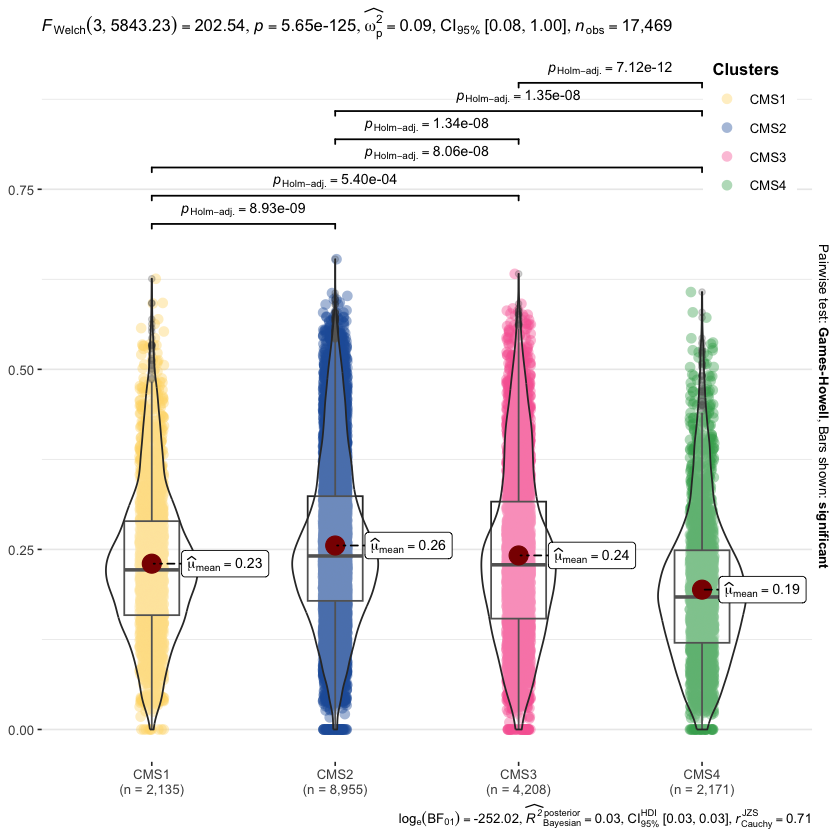

In [6]:
ggstatsplot::ggbetweenstats(
    SMC_subset_crc@meta.data %>% filter(Cell_type == "Epithelial cells"),
    x = CMS_bulk,
    y = proCSC_UCell,
    type = "p",
    plot.type = "boxviolin",
    # point.args = c(size=0)
) +
    scale_color_manual(values = c("#FED976", "#225EA8", "#F768A1", "#42AB5D")) +
    theme(
        legend.position = c(.98, 1),
        legend.justification = c("right", "top"),
        legend.box.just = "right",
        legend.margin = margin(6, 6, 6, 6),
        panel.grid.major.x = element_blank()
    ) +
    labs(title = NULL, x = NULL, y = NULL, colour = "Clusters")

# revCSC

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


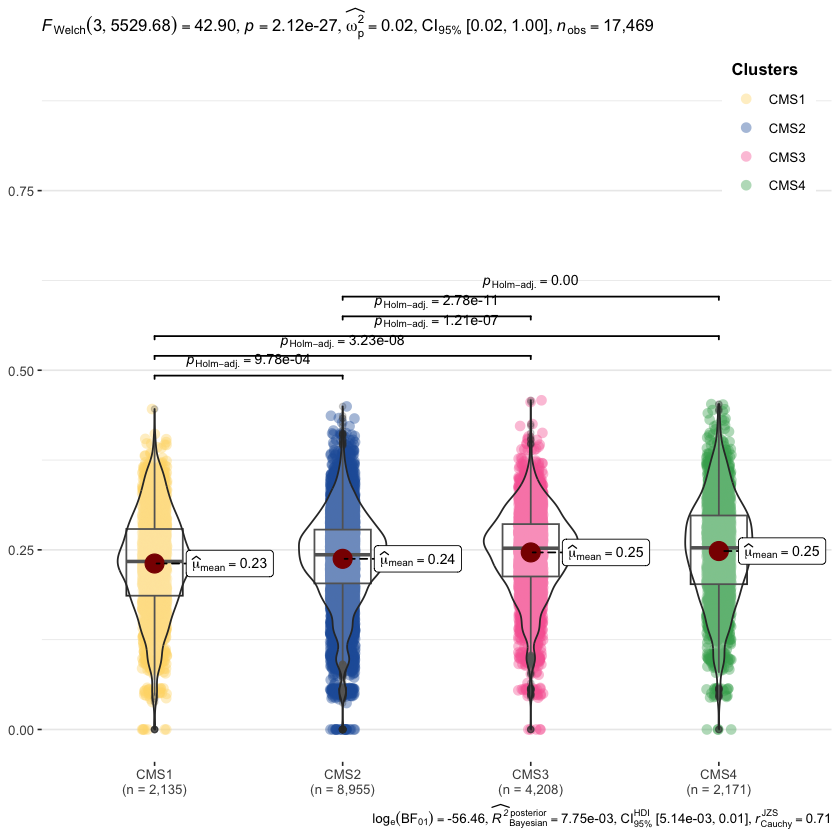

In [8]:
ggstatsplot::ggbetweenstats(
    SMC_subset_crc@meta.data %>% filter(Cell_type == "Epithelial cells"),
    x = CMS_bulk,
    y = revCSC_UCell,
    type = "p",
    plot.type = "boxviolin",
    # point.args = c(size=0)
) +
    scale_color_manual(values = c("#FED976", "#225EA8", "#F768A1", "#42AB5D")) +
        theme(
            legend.position = c(.98, 1),
            legend.justification = c("right", "top"),
            legend.box.just = "right",
            legend.margin = margin(6, 6, 6, 6),
            panel.grid.major.x = element_blank()
        ) +
    labs(title = NULL, x = NULL, y = NULL, colour = "Clusters") + ylim(0, 0.9)